In [43]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [72]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'

res = requests.get(endpoint + '?fsym=ADA&tsym=USD&limit=1000')

df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
target_col = 'close'

In [73]:
df.drop(["conversionType", "conversionSymbol", "high", "low", "volumeto"], axis = 'columns', inplace = True)
df.head(20)

,open,volumefrom,close
time,,,
2020-10-15,0.10730,14517725.18,0.10670
2020-10-16,0.10670,14150634.42,0.10430
2020-10-17,0.10430,7993435.23,0.10610
2020-10-18,0.10610,4905747.42,0.10750
2020-10-19,0.10750,11367287.09,0.10870
2020-10-20,0.10870,20036522.11,0.10240
2020-10-21,0.10240,22322860.33,0.10620
2020-10-22,0.10620,28969515.17,0.11080
2020-10-23,0.11080,16072238.51,0.10810


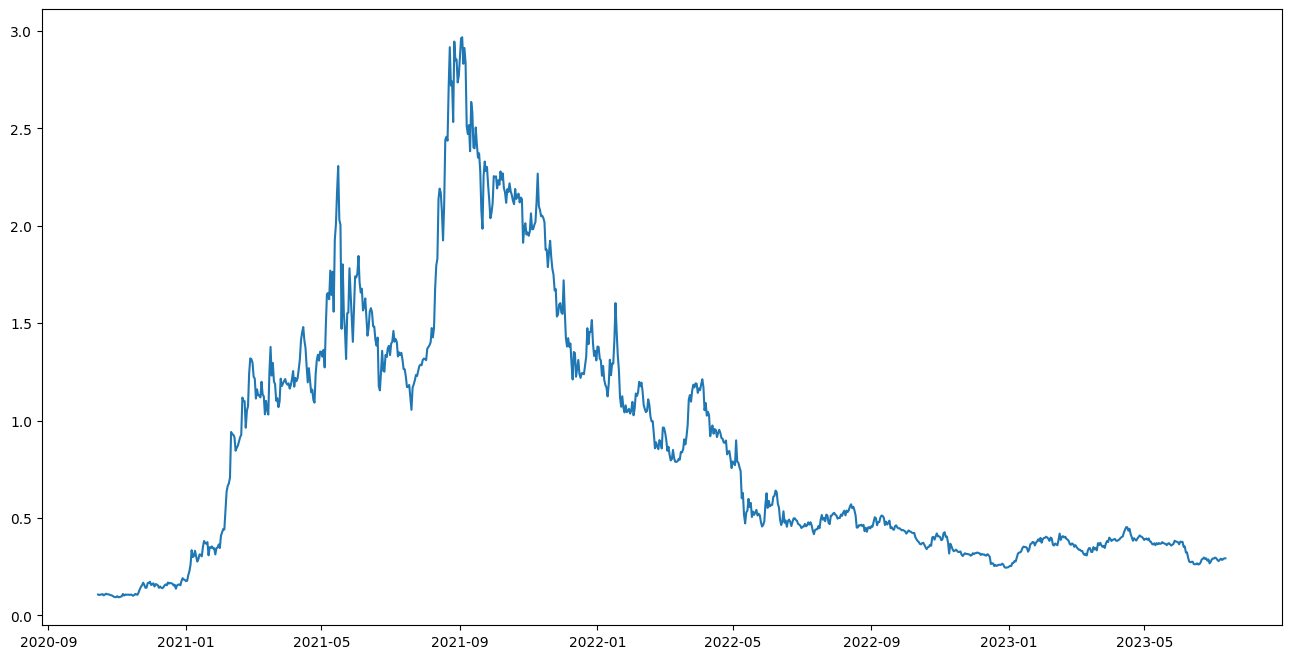

In [74]:
plt.figure(figsize=(16,8))
plt.plot(df[target_col],label='Close Price history')

In [75]:
def train_test_split(df, test_size=0.2) -> pd.DataFrame:
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [76]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

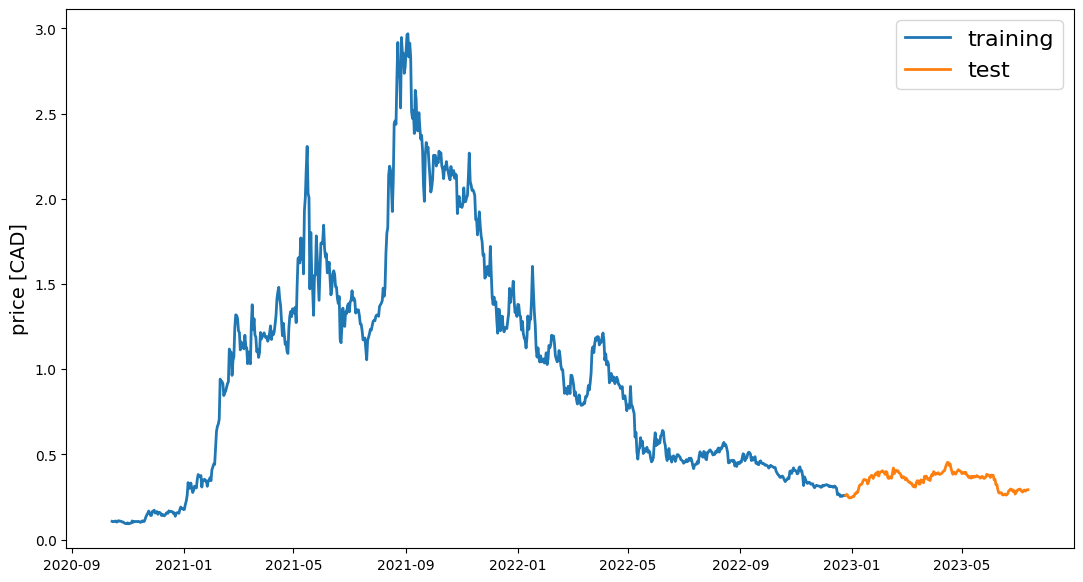

In [77]:
train, test = train_test_split(df)
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [78]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [79]:
np.random.seed(42)
window_len = 10
test_size = 0.2
zero_base = True
lstm_neurons = 200
epochs = 30
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [80]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [81]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/30
25/25 [==============================] - 3s 39ms/step - loss: 0.0347 - val_loss: 0.0054
Epoch 2/30
25/25 [==============================] - 0s 18ms/step - loss: 0.0138 - val_loss: 0.0034
Epoch 3/30
25/25 [==============================] - 0s 16ms/step - loss: 0.0120 - val_loss: 0.0032
Epoch 4/30
25/25 [==============================] - 0s 18ms/step - loss: 0.0101 - val_loss: 0.0026
Epoch 5/30
25/25 [==============================] - 0s 18ms/step - loss: 0.0099 - val_loss: 0.0030
Epoch 6/30
25/25 [==============================] - 0s 20ms/step - loss: 0.0098 - val_loss: 0.0022
Epoch 7/30
25/25 [==============================] - 0s 19ms/step - loss: 0.0097 - val_loss: 0.0025
Epoch 8/30
25/25 [==============================] - 0s 18ms/step - loss: 0.0084 - val_loss: 0.0020
Epoch 9/30
25/25 [==============================] - 0s 18ms/step - loss: 0.0083 - val_loss: 0.0020
Epoch 10/30
25/25 [==============================] - 0s 18ms/step - loss: 0.0086 - val_loss: 0.0019
Epoch 11/

{'loss': [0.03467084839940071, 0.013796531595289707, 0.01196542289108038, 0.01010855007916689, 0.009884590283036232, 0.009807138703763485, 0.009665117599070072, 0.008409781381487846, 0.008306680247187614, 0.008558898232877254, 0.007375574205070734, 0.007636403199285269, 0.0073878043331205845, 0.0072182174772024155, 0.006837429478764534, 0.006635976489633322, 0.0068238647654652596, 0.006251772865653038, 0.006483276374638081, 0.00672666123136878, 0.006555270869284868, 0.006389396730810404, 0.0066683487966656685, 0.0062286085449159145, 0.0059109837748110294, 0.006427353248000145, 0.006348239723592997, 0.006409216672182083, 0.005989785306155682, 0.005905763246119022], 'val_loss': [0.005440099164843559, 0.003421701956540346, 0.0031550272833555937, 0.0025505528319627047, 0.0029791085980832577, 0.002215081360191107, 0.0025307592004537582, 0.002007542410865426, 0.002045845612883568, 0.0018683079397305846, 0.003313946072012186, 0.002285224851220846, 0.0017797595355659723, 0.00170610670465976, 0

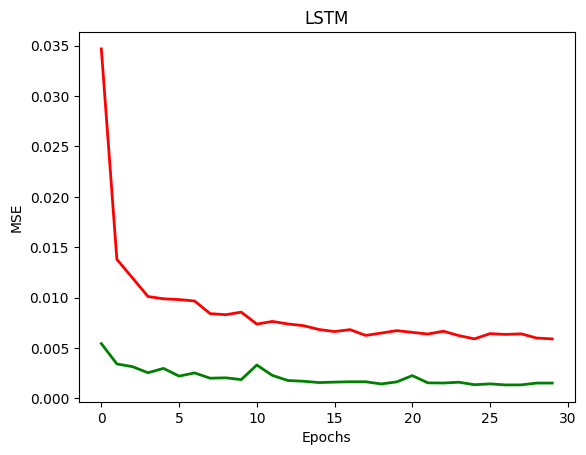

In [82]:
import matplotlib.pyplot as plt
print(history.history)
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [83]:
from sklearn.metrics import mean_absolute_error


targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

6/6 [==============================] - 0s 7ms/step


0.029584255250093585

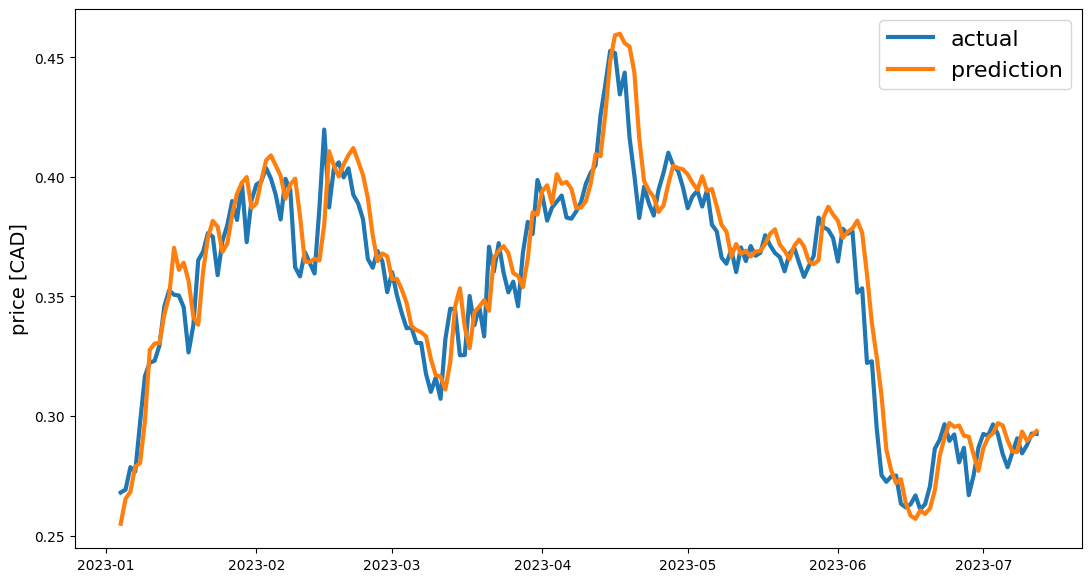

In [84]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [85]:
model.save("crypto_ada_model.h5")

c:\Users\nvtph\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
